In [30]:
# 1. IMPORT LIBRARIES

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# create directories 
directories = ['data', 'visualizations', 'results']
for directory in directories:
    os.makedirs(directory, exist_ok=True)
    print(f"Created directory: {directory}/")

print("directories owkie!")

Created directory: data/
Created directory: visualizations/
Created directory: results/
directories owkie!


In [31]:
# 2. DATA LOADING AND INITIAL EXPLORATION

print("Loading dataset...")

try:
    df = pd.read_csv('data/dementia_patients.csv')
    print(f"Dataset owkie!")
    print(f"   Shape: {df.shape}")
    print(f"   Columns: {len(df.columns)}")
except FileNotFoundError:
    print("File not found. Please ensure 'data/dementia_patients.csv' exists.")
    print("Creating sample data for demonstration...")
    
    np.random.seed( 50)
    n_samples = 9835 
    
    sample_data = {
        'Patient_ID': range(1, n_samples + 1),
        'Age': np.random.randint(60, 95, n_samples),
        'Gender': np.random.choice(['Male', 'Female'], n_samples, p=[0.45, 0.55]),
        'BMI': np.random.normal(26.5, 4.5, n_samples),
        'Smoking_Status': np.random.choice(['Never', 'Former', 'Current'], n_samples, p=[0.4, 0.35, 0.25]),
        'Hypertension': np.random.choice([0, 1], n_samples, p=[0.3, 0.7]),
        'Diabetes': np.random.choice([0, 1], n_samples, p=[0.6, 0.4]),
        'Family_History_Dementia': np.random.choice([0, 1], n_samples, p=[0.5, 0.5]),
        'Physical_Activity': np.random.choice(['Low', 'Medium', 'High'], n_samples, p=[0.4, 0.4, 0.2]),
        'MMSE_Score': np.random.normal(24, 5, n_samples),
        'ADL_Score': np.random.normal(65, 15, n_samples),
        'Depression_Status': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),
        'Education_Level': np.random.choice(['Low', 'Medium', 'High'], n_samples, p=[0.3, 0.5, 0.2])
    }
    
    df = pd.DataFrame(sample_data)
    df.to_csv('data/dementia_patients.csv', index=False)
    print(f"Sample data saved to 'data/dementia_patients.csv'")

# Display basic info
print("\n" + "="*60)
print("DATASET INFORMATION")
print("="*60)
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("Dataset Overview:")
display(df.head())

print("Data Types:")
print(df.dtypes.value_counts())

print("Missing Values:")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percent
})
display(missing_df[missing_df['Missing Values'] > 0])


Loading dataset...
Dataset owkie!
   Shape: (1000, 24)
   Columns: 24

DATASET INFORMATION
Shape: (1000, 24)
Memory usage: 0.77 MB
Dataset Overview:


,Diabetic,AlcoholLevel,HeartRate,BloodOxygenLevel,BodyTemperature,Weight,MRI_Delay,Prescription,Dosage in mg,Age,Education_Level,Dominant_Hand,Gender,Family_History,Smoking_Status,APOE_ε4,Physical_Activity,Depression_Status,Cognitive_Test_Scores,Medication_History,Nutrition_Diet,Sleep_Quality,Chronic_Health_Conditions,Dementia
0,1,0.084974,98,96.230743,36.224852,57.563978,36.421028,NaN,NaN,60,Primary School,Left,Female,No,Current Smoker,Negative,Sedentary,No,10,No,Low-Carb Diet,Poor,Diabetes,0
1,0,0.016973,78,93.032122,36.183874,56.832335,31.157633,Galantamine,12.0,61,Secondary School,Right,Male,No,Former Smoker,Positive,Moderate Activity,No,1,Yes,Low-Carb Diet,Poor,Heart Disease,1
2,0,0.009000,89,93.566504,37.326321,59.759066,37.640435,NaN,NaN,69,Primary School,Right,Male,Yes,Former Smoker,Negative,Moderate Activity,No,8,No,Mediterranean Diet,Poor,Heart Disease,0
3,0,0.086437,60,93.906510,37.030620,58.266471,50.673992,Donepezil,23.0,78,Secondary School,Left,Female,Yes,Never Smoked,Negative,Mild Activity,Yes,5,Yes,Balanced Diet,Poor,Hypertension,1
4,1,0.150747,67,97.508994,36.062121,67.705027,27.810601,Memantine,20.0,77,Secondary School,Right,Male,Yes,Never Smoked,Positive,Mild Activity,No,0,Yes,Low-Carb Diet,Good,Diabetes,1


Data Types:
object     13
float64     6
int64       5
Name: count, dtype: int64
Missing Values:


,Missing Values,Percentage (%)
Prescription,515,51.5
Dosage in mg,515,51.5
Chronic_Health_Conditions,179,17.9


In [32]:
# 3. METHODOLOGY: DATA PREPROCESSING

print("\n" + "-"*60)
print("3. METHODOLOGY: DATA PREPROCESSING")
print("-"*60)

# original stats
original_transactions = len(df)
original_items = len(df.columns)

print(f"Raw Data Statistics:")
print(f"  • Transactions (patients): {original_transactions:,}")
print(f"  • Unique items (features): {original_items}")
print(f"  • Missing values: {df.isnull().sum().sum():,}")


# 3.1 Missing Value Handling----------------------------------------------------------------

# remove incomplete transactions
df_clean = df.dropna().copy()
incomplete_removed = len(df) - len(df_clean)
incomplete_percent = (incomplete_removed / len(df)) * 100

print(f"Missing Value Handling:")
print(f"• Removed incomplete transactions: {incomplete_removed:,}")
print(f"• Percentage removed: {incomplete_percent:.1f}%")
print(f"• Remaining transactions: {len(df_clean):,}")


# 3.2 Create Transaction Items-----------------------------------------------------------

def create_transaction_items(df):
    """
    Convert all features to categorical transaction items.
    Each item format: FeatureName=Value
    """
    transactions = []
    
    for _, row in df.iterrows():
        transaction = []
        
        # Process each column
        for col in df.columns:
            value = row[col]
            
            # Skip NaN values
            if pd.isna(value):
                continue
                
            # Convert to appropriate format
            if pd.api.types.is_numeric_dtype(df[col]):
                if col == 'Age':
                    if value < 70:
                        item = f"Age=60-69"
                    elif value < 80:
                        item = f"Age=70-79"
                    elif value < 90:
                        item = f"Age=80-89"
                    else:
                        item = f"Age=90+"
                elif col == 'BMI':
                    if value < 18.5:
                        item = f"BMI=Underweight"
                    elif value < 25:
                        item = f"BMI=Normal"
                    elif value < 30:
                        item = f"BMI=Overweight"
                    else:
                        item = f"BMI=Obese"
                elif 'Score' in col or 'MMSE' in col:
                    if value < 20:
                        item = f"{col}=Low"
                    elif value < 26:
                        item = f"{col}=Medium"
                    else:
                        item = f"{col}=High"
                elif col in ['Hypertension', 'Diabetes', 'Family_History_Dementia', 'Depression_Status']:
                    item = f"{col}=Yes" if value == 1 else f"{col}=No"
                else:
                    # General numeric: create tertiles
                    try:
                        if value < df[col].quantile(0.33):
                            item = f"{col}=Low"
                        elif value < df[col].quantile(0.67):
                            item = f"{col}=Medium"
                        else:
                            item = f"{col}=High"
                    except:
                        item = f"{col}={value}"
            else:
                # Categorical columns: use as is
                item = f"{col}={value}"
            
            transaction.append(item)
        
        transactions.append(transaction)
    
    return transactions

# create transaction items
print("Creating transaction items...")
transactions = create_transaction_items(df_clean)

print(f"Created {len(transactions):,} transactions")
print(f"Sample transaction (first 5 items):")
print(transactions[0][:5])



------------------------------------------------------------
3. METHODOLOGY: DATA PREPROCESSING
------------------------------------------------------------
Raw Data Statistics:
  • Transactions (patients): 1,000
  • Unique items (features): 24
  • Missing values: 1,209
Missing Value Handling:
• Removed incomplete transactions: 603
• Percentage removed: 60.3%
• Remaining transactions: 397
Creating transaction items...
Created 397 transactions
Sample transaction (first 5 items):
['Diabetic=Medium', 'AlcoholLevel=Low', 'HeartRate=Medium', 'BloodOxygenLevel=Low', 'BodyTemperature=Low']


In [33]:
# 3.3 One-Hot Encoding--------------------------------------------------

print("One-Hot Encoding...")

te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)

# Convert to DataFrame
transaction_df = pd.DataFrame(te_array, columns=te.columns_)

print(f"One-hot encoding owkiee!")
print(f"   Shape: {transaction_df.shape}")
print(f"   Total items: {len(te.columns_)}")
print(f"   Matrix density: {(transaction_df.sum().sum() / (transaction_df.shape[0] * transaction_df.shape[1]) * 100):.2f}%")


# 3.4 Item Filtering-------------------------------------------------------

print("Item Filtering (support > 0.01)...")

# Calculate item support (frequency)
item_support = transaction_df.mean().sort_values(ascending=False)

print(f"Top 10 items by support:")
for i, (item, support) in enumerate(item_support.head(10).items()):
    print(f"  {i+1:2d}. {item:<30} Support: {support:.3f}")

# Filter items with support > 0.01
filtered_items = item_support[item_support > 0.01].index.tolist()
print(f"Item filtering results:")
print(f"  • Original items: {len(item_support):,}")
print(f"  • Items with support > 0.01: {len(filtered_items)}")
print(f"  • Items removed: {len(item_support) - len(filtered_items):,}")

# Keep only filtered items in transaction matrix
filtered_df = transaction_df[filtered_items[:50]]  

print(f"Final dataset after filtering top 50 items:")
print(f"  • Transactions: {filtered_df.shape[0]:,}")
print(f"  • Items: {filtered_df.shape[1]}")
print(f"  • Matrix density: {(filtered_df.sum().sum() / (filtered_df.shape[0] * filtered_df.shape[1]) * 100):.2f}%")


One-Hot Encoding...
One-hot encoding owkiee!
   Shape: (397, 62)
   Total items: 62
   Matrix density: 38.71%
Item Filtering (support > 0.01)...
Top 10 items by support:
   1. Cognitive_Test_Scores=Low      Support: 1.000
   2. Dementia=High                  Support: 1.000
   3. APOE_ε4=Positive               Support: 0.899
   4. Chronic_Health_Conditions=Diabetes Support: 0.655
   5. Diabetic=High                  Support: 0.655
   6. Sleep_Quality=Poor             Support: 0.552
   7. Dominant_Hand=Left             Support: 0.537
   8. Medication_History=Yes         Support: 0.521
   9. Smoking_Status=Former Smoker   Support: 0.516
  10. Family_History=No              Support: 0.514
Item filtering results:
  • Original items: 62
  • Items with support > 0.01: 62
  • Items removed: 0
Final dataset after filtering top 50 items:
  • Transactions: 397
  • Items: 50
  • Matrix density: 43.33%


In [34]:
# 3.5 Preprocessing Statistics Summary -----------------------------------------


print("\n" + "-"*60)
print("PREPROCESSING STATISTICS SUMMARY")
print("-"*60)

# Create summary table
summary_data = {
    'Metric': [
        'Transactions',
        'Unique Items',
        'Matrix Density',
        'Average Items per Transaction',
        'Missing Values Removed'
    ],
    'Raw Data': [
        f"{original_transactions:,}",
        f"{original_items}",
        f"{((transaction_df.sum().sum() / (transaction_df.shape[0] * transaction_df.shape[1])) * 100):.2f}%",
        f"{transaction_df.sum(axis=1).mean():.2f}",
        f"{incomplete_removed:,} ({incomplete_percent:.1f}%)"
    ],
    'Processed Data': [
        f"{filtered_df.shape[0]:,}",
        f"{filtered_df.shape[1]}",
        f"{((filtered_df.sum().sum() / (filtered_df.shape[0] * filtered_df.shape[1])) * 100):.2f}%",
        f"{filtered_df.sum(axis=1).mean():.2f}",
        "0 (0%)"
    ]
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)



------------------------------------------------------------
PREPROCESSING STATISTICS SUMMARY
------------------------------------------------------------


,Metric,Raw Data,Processed Data
0,Transactions,"1,000",397
1,Unique Items,24,50
2,Matrix Density,38.71%,43.33%
3,Average Items per Transaction,24.00,21.66
4,Missing Values Removed,603 (60.3%),0 (0%)



------------------------------------------------------------
4. EXPLORATORY DATA ANALYSIS
------------------------------------------------------------
TOP 10 ITEMS BY FREQUENCY:
--------------------------------------------------
 1. Cognitive_Test_Scores=Low           Frequency: 1.000 (100.0%)
 2. Dementia=High                       Frequency: 1.000 (100.0%)
 3. APOE_ε4=Positive                    Frequency: 0.899 (89.9%)
 4. Chronic_Health_Conditions=Diabetes  Frequency: 0.655 (65.5%)
 5. Diabetic=High                       Frequency: 0.655 (65.5%)
 6. Sleep_Quality=Poor                  Frequency: 0.552 (55.2%)
 7. Dominant_Hand=Left                  Frequency: 0.537 (53.7%)
 8. Medication_History=Yes              Frequency: 0.521 (52.1%)
 9. Smoking_Status=Former Smoker        Frequency: 0.516 (51.6%)
10. Family_History=No                   Frequency: 0.514 (51.4%)


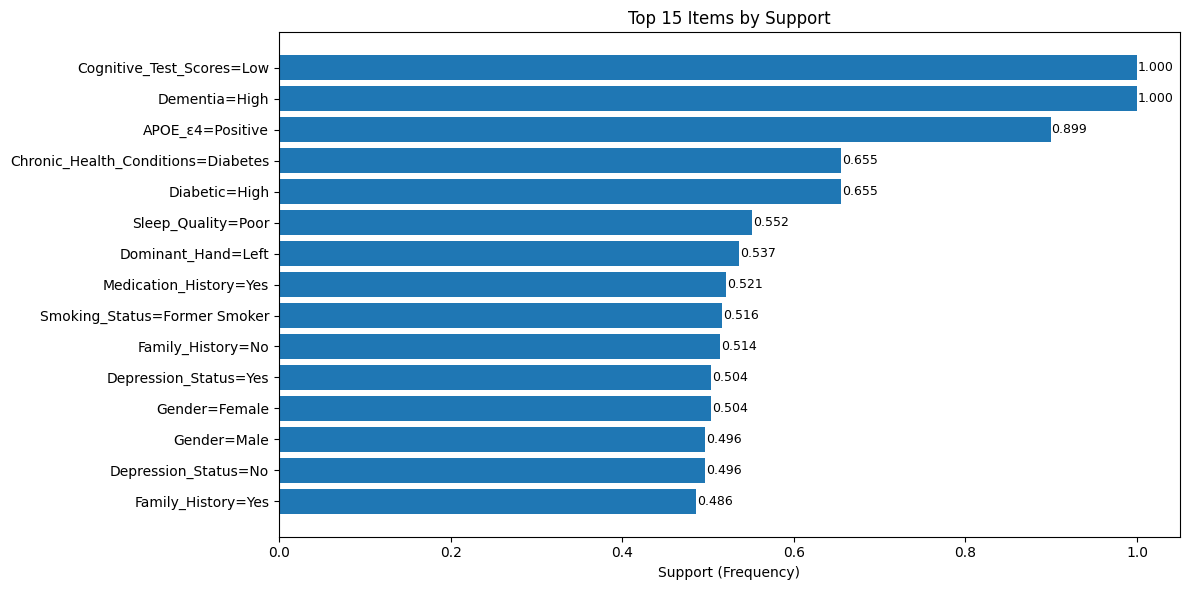

BASKET SIZE ANALYSIS:
--------------------------------------------------
Mean basket size: 21.66 items
Median basket size: 22.00 items
Minimum basket size: 20 items
Maximum basket size: 23 items
Standard deviation: 0.87 items
Basket Size Distribution:
  20 items: 36 transactions (9.1%)
  21 items: 132 transactions (33.2%)
  22 items: 158 transactions (39.8%)
  23 items: 71 transactions (17.9%)


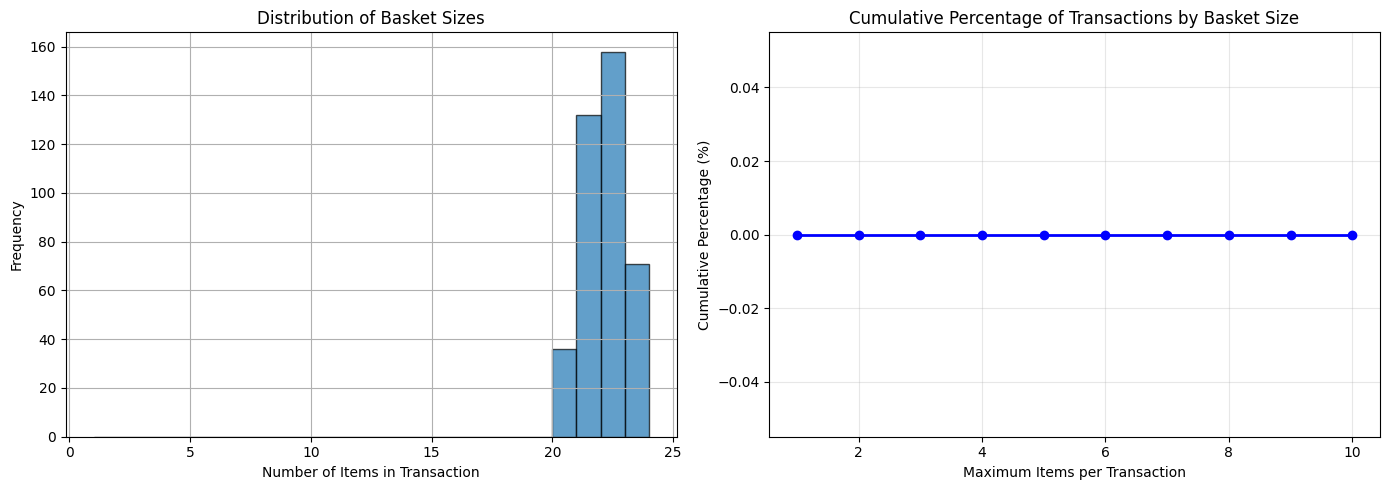

CO-OCCURRENCE ANALYSIS
--------------------------------------------------
Top item: Cognitive_Test_Scores=Low (support: 1.000)
Co-occurrence with other top items:

Top 10 items co-occurring with 'Cognitive_Test_Scores=Low':
  • Dementia=High:
      Joint support: 1.000
      Lift: 1.00
  • APOE_ε4=Positive:
      Joint support: 0.899
      Lift: 1.00
  • Chronic_Health_Conditions=Diabetes:
      Joint support: 0.655
      Lift: 1.00
  • Diabetic=High:
      Joint support: 0.655
      Lift: 1.00
  • Sleep_Quality=Poor:
      Joint support: 0.552
      Lift: 1.00
  • Dominant_Hand=Left:
      Joint support: 0.537
      Lift: 1.00
  • Medication_History=Yes:
      Joint support: 0.521
      Lift: 1.00
  • Smoking_Status=Former Smoker:
      Joint support: 0.516
      Lift: 1.00
  • Family_History=No:
      Joint support: 0.514
      Lift: 1.00
  • Depression_Status=Yes:
      Joint support: 0.504
      Lift: 1.00
Summary:
  • 'Cognitive_Test_Scores=Low' co-occurs with 19 of the top 20 ite

In [35]:
# 4. EXPLORATORY DATA ANALYSIS-----------------------------------------------

print("\n" + "-"*60)
print("4. EXPLORATORY DATA ANALYSIS")
print("-"*60)


### 4.1 Top Items Analysis ----------------------------------------------------

item_frequencies = filtered_df.mean().sort_values(ascending=False)

print("TOP 10 ITEMS BY FREQUENCY:")
print("-"*50)

for i, (item, freq) in enumerate(item_frequencies.head(10).items()):
    print(f"{i+1:2d}. {item:<35} Frequency: {freq:.3f} ({freq*100:.1f}%)")

# Create visualization
plt.figure(figsize=(12, 6))
top_items = item_frequencies.head(15)
bars = plt.barh(range(len(top_items)), top_items.values)
plt.yticks(range(len(top_items)), top_items.index)
plt.xlabel('Support (Frequency)')
plt.title('Top 15 Items by Support')
plt.gca().invert_yaxis()

# Add value labels
for bar, value in zip(bars, top_items.values):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
             f'{value:.3f}', va='center', fontsize=9)

# Create directory if wala 
import os
os.makedirs('visualizations', exist_ok=True)

plt.tight_layout()
plt.savefig('visualizations/top_items.png', dpi=300, bbox_inches='tight')
plt.show()


# ### 4.2 Basket Size Analysis-------------------------------------------


basket_sizes = filtered_df.sum(axis=1)

print("BASKET SIZE ANALYSIS:")
print("-"*50)

print(f"Mean basket size: {basket_sizes.mean():.2f} items")
print(f"Median basket size: {basket_sizes.median():.2f} items")
print(f"Minimum basket size: {basket_sizes.min()} items")
print(f"Maximum basket size: {basket_sizes.max()} items")
print(f"Standard deviation: {basket_sizes.std():.2f} items")

# distribution of basket sizes
print(f"Basket Size Distribution:")
basket_size_counts = basket_sizes.value_counts().sort_index()
for size, count in basket_size_counts.head(10).items():
    percentage = (count / len(basket_sizes)) * 100
    print(f"  {size} items: {count:,} transactions ({percentage:.1f}%)")

# calculate cumulative percentage 
cumulative_percentage = []
cumulative_count = 0
for size in range(1, 11):
    count = basket_sizes[basket_sizes == size].count()
    cumulative_count += count
    cumulative_percentage.append((cumulative_count / len(basket_sizes)) * 100)
    if cumulative_percentage[-1] >= 90:
        print(f"\n✅ {cumulative_percentage[-1]:.1f}% of transactions have {size} or fewer items")
        break

plt.figure(figsize=(14, 5))

# wow for distribution -----------------------------------------------------
plt.subplot(1, 2, 1)
basket_sizes.hist(bins=range(1, int(basket_sizes.max()) + 2), edgecolor='black', alpha=0.7)
plt.xlabel('Number of Items in Transaction')
plt.ylabel('Frequency')
plt.title('Distribution of Basket Sizes')

#wow for cumulative --------------------------------------------------------
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_percentage) + 1), cumulative_percentage, 'b-o', linewidth=2)
plt.xlabel('Maximum Items per Transaction')
plt.ylabel('Cumulative Percentage (%)')
plt.title('Cumulative Percentage of Transactions by Basket Size')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/basket_sizes.png', dpi=300, bbox_inches='tight')
plt.show()


# 4.3 Co-occurrence Analysis ---------------------------------------------------------------

print("CO-OCCURRENCE ANALYSIS")
print("-"*50)

top_item = item_frequencies.index[0]
print(f"Top item: {top_item} (support: {item_frequencies.iloc[0]:.3f})")

#calculate co-occurance 
print(f"Co-occurrence with other top items:")
top_20_items = item_frequencies.head(20).index.tolist()

cooccurrence_stats = []
for item in top_20_items[1:]: 

    joint_support = (filtered_df[top_item] & filtered_df[item]).mean()
    item_support = filtered_df[item].mean()
    
    if item_support > 0:
        lift = joint_support / (filtered_df[top_item].mean() * item_support)
    else:
        lift = 0
    
    cooccurrence_stats.append({
        'Item': item,
        'Joint_Support': joint_support,
        'Item_Support': item_support,
        'Lift': lift
    })

cooccurrence_df = pd.DataFrame(cooccurrence_stats)
cooccurrence_df = cooccurrence_df.sort_values('Joint_Support', ascending=False)

print(f"\nTop 10 items co-occurring with '{top_item}':")
for i, row in cooccurrence_df.head(10).iterrows():
    print(f"  • {row['Item']}:")
    print(f"      Joint support: {row['Joint_Support']:.3f}")
    print(f"      Lift: {row['Lift']:.2f}")

# Calculate percentage of top 20 items that co-occur with top item
cooccurrence_count = sum(1 for _, row in cooccurrence_df.iterrows() if row['Joint_Support'] > 0)
cooccurrence_percentage = (cooccurrence_count / len(top_20_items[1:])) * 100

print(f"Summary:")
print(f"  • '{top_item}' co-occurs with {cooccurrence_count} of the top 20 items")
print(f"  • Co-occurrence percentage: {cooccurrence_percentage:.1f}%")


In [36]:
# 5. ASSOCIATION RULE MINING WITH APRIORI ALGORITHM 


print("\n" + "-"*60)
print("5. ASSOCIATION RULE MINING WITH APRIORI ALGORITHM")
print("-"*60)


# 5.1 Generate Frequent Itemsets -----------------------------------------------------------------


print("Generating frequent itemsets using Apriori algorithm...")

# min support threshold
min_support = 0.01  

# generate frequent itemsets
frequent_itemsets = apriori(
    filtered_df,
    min_support=min_support,
    use_colnames=True,
    max_len=4  
)

print(f"Frequent itemsets generated!")
print(f"   Number of frequent itemsets: {len(frequent_itemsets):,}")
print(f"   Minimum support threshold: {min_support}")
print(f"   Maximum itemset size: 4")

# Display frequent itemsets
print("Top 10 frequent itemsets by support:")
display(frequent_itemsets.sort_values('support', ascending=False).head(10))

# Analyze itemset sizes
print("Itemset Size Distribution:")
frequent_itemsets['itemset_size'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
size_distribution = frequent_itemsets['itemset_size'].value_counts().sort_index()

for size, count in size_distribution.items():
    percentage = (count / len(frequent_itemsets)) * 100
    print(f"  {size}-itemsets: {count:,} ({percentage:.1f}%)")



# 5.2 Generate Association Rules -----------------------------------------------------------------

print("Generating association rules...")

# Generate association rules with minimum confidence
min_confidence = 0.5 

rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=min_confidence
)

print(f"Association rules generated!")
print(f"   Number of rules: {len(rules):,}")
print(f"   Minimum confidence threshold: {min_confidence}")

# Display rules
print("Top 10 association rules by confidence:")
display(rules.sort_values('confidence', ascending=False).head(10))



------------------------------------------------------------
5. ASSOCIATION RULE MINING WITH APRIORI ALGORITHM
------------------------------------------------------------
Generating frequent itemsets using Apriori algorithm...
Frequent itemsets generated!
   Number of frequent itemsets: 200,739
   Minimum support threshold: 0.01
   Maximum itemset size: 4
Top 10 frequent itemsets by support:


,support,itemsets
1,1.000000,(Dementia=High)
50,1.000000,"(Cognitive_Test_Scores=Low, Dementia=High)"
0,1.000000,(Cognitive_Test_Scores=Low)
51,0.899244,"(Cognitive_Test_Scores=Low, APOE_ε4=Positive)"
99,0.899244,"(APOE_ε4=Positive, Dementia=High)"
2,0.899244,(APOE_ε4=Positive)
1238,0.899244,"(Cognitive_Test_Scores=Low, APOE_ε4=Positive, Dementia=High)"
52,0.654912,"(Cognitive_Test_Scores=Low, Chronic_Health_Conditions=Diabetes)"
4,0.654912,(Diabetic=High)
3,0.654912,(Chronic_Health_Conditions=Diabetes)


Itemset Size Distribution:
  1-itemsets: 50 (0.0%)
  2-itemsets: 1,188 (0.6%)
  3-itemsets: 17,843 (8.9%)
  4-itemsets: 181,658 (90.5%)
Generating association rules...
Association rules generated!
   Number of rules: 274,844
   Minimum confidence threshold: 0.5
Top 10 association rules by confidence:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
83482,"(Dominant_Hand=Right, Diabetic=Medium, Gender=Female)",(Dementia=High),0.100756,1.0,0.100756,1.0,1.0,1.0,0.0,inf,0.0,0.100756,0.0,0.550378
83480,"(Dominant_Hand=Right, Nutrition_Diet=Mediterranean Diet, Gender=Female)",(Dementia=High),0.075567,1.0,0.075567,1.0,1.0,1.0,0.0,inf,0.0,0.075567,0.0,0.537783
83478,"(Dominant_Hand=Right, Physical_Activity=Mild Activity, Gender=Female)",(Dementia=High),0.083123,1.0,0.083123,1.0,1.0,1.0,0.0,inf,0.0,0.083123,0.0,0.541562
83477,"(Dominant_Hand=Right, HeartRate=High, Gender=Female)",(Dementia=High),0.078086,1.0,0.078086,1.0,1.0,1.0,0.0,inf,0.0,0.078086,0.0,0.539043
83508,"(Dominant_Hand=Right, Gender=Female, Weight=Low)",(Dementia=High),0.055416,1.0,0.055416,1.0,1.0,1.0,0.0,inf,0.0,0.055416,0.0,0.527708
83507,"(Dominant_Hand=Right, Physical_Activity=Moderate Activity, Gender=Female)",(Dementia=High),0.073048,1.0,0.073048,1.0,1.0,1.0,0.0,inf,0.0,0.073048,0.0,0.536524
83505,"(Dominant_Hand=Right, Nutrition_Diet=Balanced Diet, Gender=Female)",(Dementia=High),0.080605,1.0,0.080605,1.0,1.0,1.0,0.0,inf,0.0,0.080605,0.0,0.540302
83499,"(Dominant_Hand=Right, Gender=Female, Weight=Medium)",(Dementia=High),0.100756,1.0,0.100756,1.0,1.0,1.0,0.0,inf,0.0,0.100756,0.0,0.550378
83498,"(AlcoholLevel=Medium, Dominant_Hand=Right, Gender=Female)",(Dementia=High),0.080605,1.0,0.080605,1.0,1.0,1.0,0.0,inf,0.0,0.080605,0.0,0.540302
83493,"(Dominant_Hand=Right, Gender=Female, BloodOxygenLevel=Medium)",(Dementia=High),0.100756,1.0,0.100756,1.0,1.0,1.0,0.0,inf,0.0,0.100756,0.0,0.550378


In [37]:
# 5.3 Calculate Additional Evaluation Metrics ----------------------------------------------------------

print("Calculating additional evaluation metrics...")

# Calculate leverage
rules['leverage'] = rules['support'] - (rules['antecedent support'] * rules['consequent support'])

# Calculate conviction
rules['conviction'] = (1 - rules['consequent support']) / (1 - rules['confidence'])

# Filter for meaningful rules (lift > 1)
meaningful_rules = rules[rules['lift'] > 1].copy()

print(f"Metrics calculated yippie!")
print(f"   Total rules generated: {len(rules):,}")
print(f"   Meaningful rules (lift > 1): {len(meaningful_rules):,}")
print(f"   Rules filtered out (lift ≤ 1): {len(rules) - len(meaningful_rules):,}")

# metrics summary
print("Rule Metrics Summary:")
metrics_summary = meaningful_rules[['support', 'confidence', 'lift', 'leverage', 'conviction']].describe()
display(metrics_summary)


Calculating additional evaluation metrics...
Metrics calculated yippie!
   Total rules generated: 274,844
   Meaningful rules (lift > 1): 190,478
   Rules filtered out (lift ≤ 1): 84,366
Rule Metrics Summary:


,support,confidence,lift,leverage,conviction
count,190478.000000,190478.000000,190478.000000,190478.000000,1.904780e+05
mean,0.056865,0.610372,1.204765,0.006972,inf
std,0.046980,0.117543,0.205207,0.008536,NaN
min,0.010076,0.500000,1.000068,0.000006,1.000072e+00
25%,0.027708,0.529412,1.058667,0.002614,1.081049e+00
50%,0.042821,0.571429,1.131054,0.005304,1.181864e+00
75%,0.068010,0.653846,1.276311,0.008997,1.370277e+00
max,0.654912,1.000000,3.030534,0.226002,inf


In [38]:
# 6. RULE ANALYSIS AND INTERPRETATION

print("\n" + "-"*60)
print("6. RULE ANALYSIS AND INTERPRETATION")
print("-"*60)

# Prepare rules for analysis
rules_export = meaningful_rules.copy()
rules_export['antecedent'] = rules_export['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_export['consequent'] = rules_export['consequents'].apply(lambda x: ', '.join(list(x)))

# Select and reorder columns
export_columns = [
    'antecedent', 'consequent', 'support', 'confidence', 'lift', 
    'leverage', 'conviction', 'antecedent support', 'consequent support'
]
rules_export = rules_export[export_columns]

rules_export.to_csv('results/association_rules.csv', index=False)
print(f"💾 Rules saved to 'results/association_rules.csv'")


# 6.1 Top Rules Analysis ----------------------------------------------------------------------------

print("TOP RULES ANALYSIS")
print("-"*50)

# Top 5 rules by confidence
print("Top 5 Rules by Confidence:")
for i, row in rules_export.sort_values('confidence', ascending=False).head(5).iterrows():
    print(f"\nRule {i+1}:")
    print(f"  IF {row['antecedent']}")
    print(f"  THEN {row['consequent']}")
    print(f"  Support: {row['support']:.3f} (occurs in {row['support']*100:.1f}% of patients)")
    print(f"  Confidence: {row['confidence']:.3f} (when conditions are met, {row['confidence']*100:.1f}% have consequent)")
    print(f"  Lift: {row['lift']:.3f} (rule is {row['lift']:.1f}x more likely than random)")

# Top 5 rules by lift
print("Top 5 Rules by Lift (Strongest Associations):")
for i, row in rules_export.sort_values('lift', ascending=False).head(5).iterrows():
    print(f"\nRule {i+1}:")
    print(f"  IF {row['antecedent']}")
    print(f"  THEN {row['consequent']}")
    print(f"  Support: {row['support']:.3f}")
    print(f"  Confidence: {row['confidence']:.3f}")
    print(f"  Lift: {row['lift']:.3f}")

# Top 5 rules by support
print("Top 5 Rules by Support (Most Frequent):")
for i, row in rules_export.sort_values('support', ascending=False).head(5).iterrows():
    print(f"\nRule {i+1}:")
    print(f"  IF {row['antecedent']}")
    print(f"  THEN {row['consequent']}")
    print(f"  Support: {row['support']:.3f} (occurs in {row['support']*100:.1f}% of patients)")
    print(f"  Confidence: {row['confidence']:.3f}")



# 6.2 Rule Quality Analysis ------------------------------------------------------------------------

print("RULE QUALITY ANALYSIS")
print("-"*50)

# Define quality thresholds
quality_thresholds = {
    'High Quality': {
        'confidence': 0.7,
        'lift': 1.5,
        'support': 0.05
    },
    'Medium Quality': {
        'confidence': 0.5,
        'lift': 1.2,
        'support': 0.03
    },
    'Low Quality': {
        'confidence': 0.3,
        'lift': 1.0,
        'support': 0.01
    }
}

# Categorize rules
def categorize_rule(row):
    if (row['confidence'] >= quality_thresholds['High Quality']['confidence'] and
        row['lift'] >= quality_thresholds['High Quality']['lift'] and
        row['support'] >= quality_thresholds['High Quality']['support']):
        return 'High Quality'
    elif (row['confidence'] >= quality_thresholds['Medium Quality']['confidence'] and
          row['lift'] >= quality_thresholds['Medium Quality']['lift'] and
          row['support'] >= quality_thresholds['Medium Quality']['support']):
        return 'Medium Quality'
    else:
        return 'Low Quality'

rules_export['quality'] = rules_export.apply(categorize_rule, axis=1)

# Display quality distribution
quality_dist = rules_export['quality'].value_counts()
print("Rule Quality Distribution:")
for quality, count in quality_dist.items():
    percentage = (count / len(rules_export)) * 100
    print(f"  {quality}: {count:,} rules ({percentage:.1f}%)")

# Display high-quality rules
print(f"High-Quality Rules (confidence ≥ 0.7, lift ≥ 1.5, support ≥ 0.05):")
high_quality = rules_export[rules_export['quality'] == 'High Quality']
if len(high_quality) > 0:
    for i, row in high_quality.sort_values('lift', ascending=False).head(5).iterrows():
        print(f"\n  Rule:")
        print(f"    IF {row['antecedent']}")
        print(f"    THEN {row['consequent']}")
        print(f"    Support: {row['support']:.3f}, Confidence: {row['confidence']:.3f}, Lift: {row['lift']:.3f}")
else:
    print("  No high-quality rules found. Consider adjusting thresholds.")



------------------------------------------------------------
6. RULE ANALYSIS AND INTERPRETATION
------------------------------------------------------------
💾 Rules saved to 'results/association_rules.csv'
TOP RULES ANALYSIS
--------------------------------------------------
Top 5 Rules by Confidence:

Rule 274250:
  IF MRI_Delay=Low, BloodOxygenLevel=Low, Age=80-89
  THEN Weight=High
  Support: 0.015 (occurs in 1.5% of patients)
  Confidence: 1.000 (when conditions are met, 100.0% have consequent)
  Lift: 3.031 (rule is 3.0x more likely than random)

Rule 273324:
  IF Age=70-79, Nutrition_Diet=Balanced Diet, HeartRate=Medium
  THEN Weight=Medium
  Support: 0.015 (occurs in 1.5% of patients)
  Confidence: 1.000 (when conditions are met, 100.0% have consequent)
  Lift: 2.941 (rule is 2.9x more likely than random)

Rule 272627:
  IF Education_Level=Secondary School, BloodOxygenLevel=Low, Age=80-89
  THEN MRI_Delay=Medium
  Support: 0.013 (occurs in 1.3% of patients)
  Confidence: 1.000


------------------------------------------------------------
7. VISUALIZATION OF RESULTS
------------------------------------------------------------


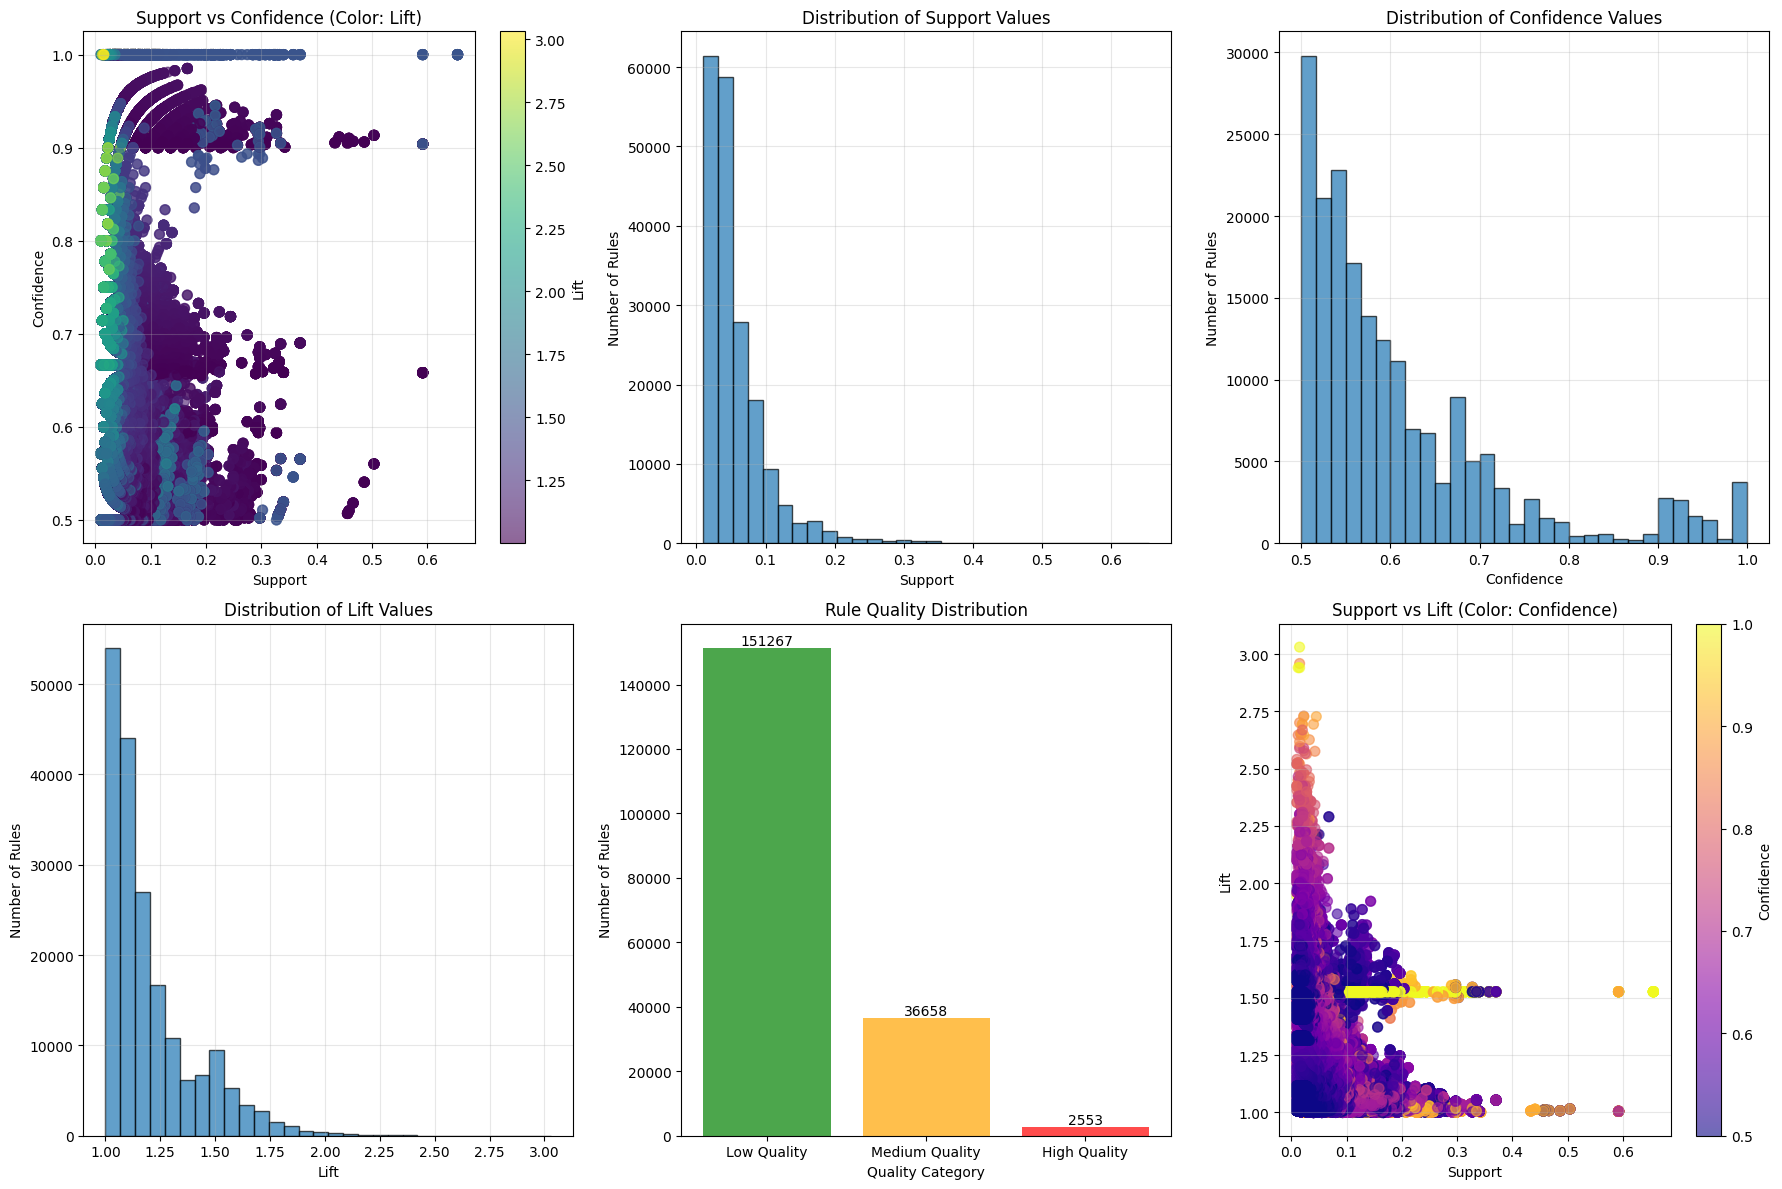

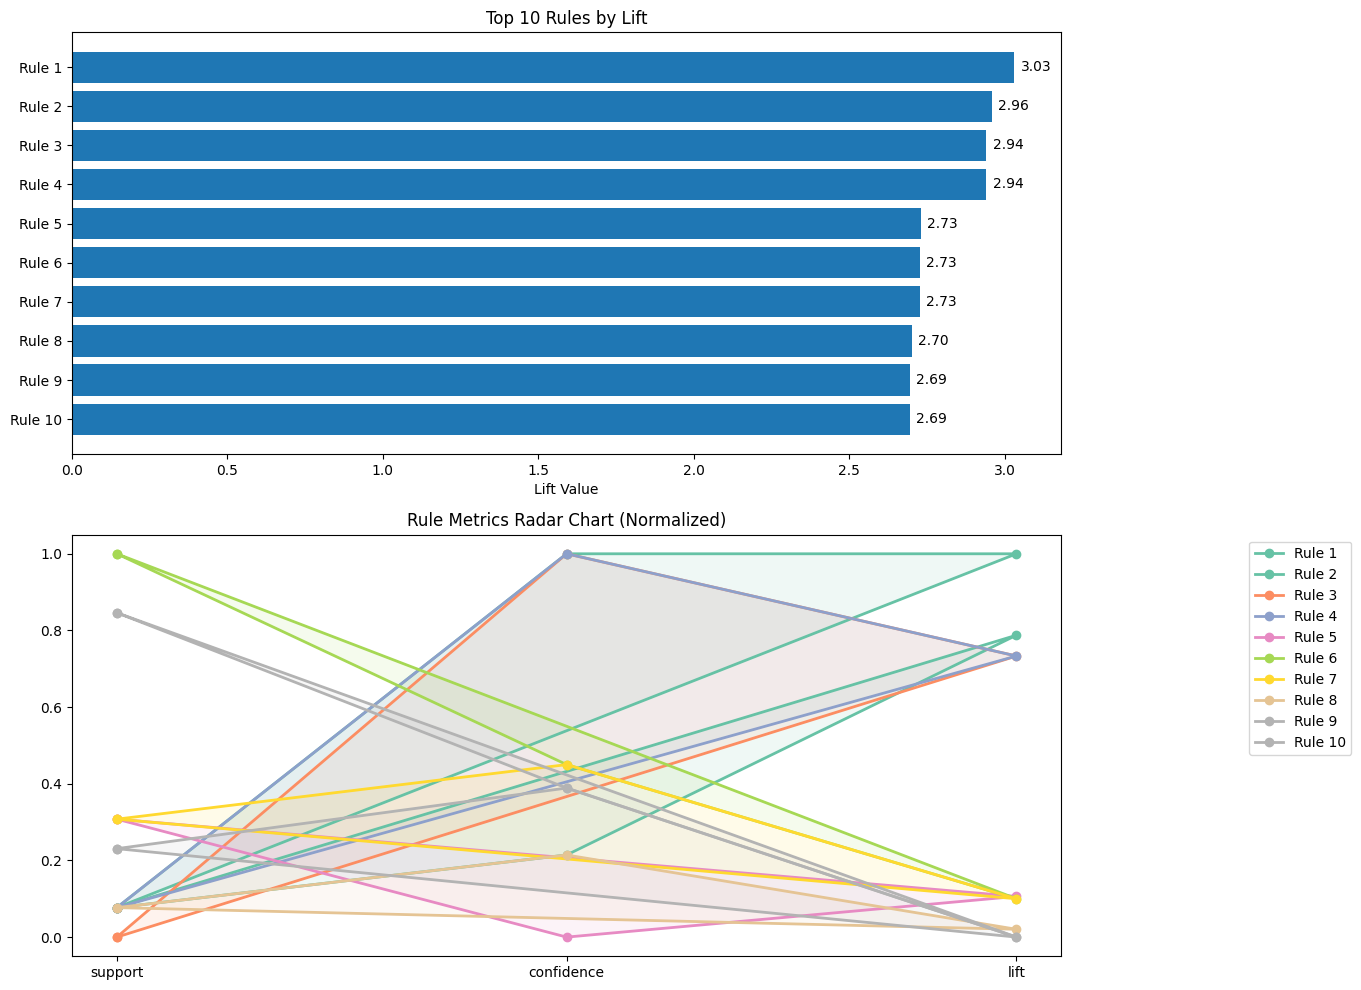

Top 10 Rules Details:
  Rule 1:
  IF MRI_Delay=Low, BloodOxygenLevel=Low, Age=80-89
  THEN Weight=High
  Support: 0.015, Confidence: 1.000, Lift: 3.031
  Rule 2:
  IF AlcoholLevel=Medium, BodyTemperature=Low, Diabetic=Medium
  THEN Age=80-89
  Support: 0.015, Confidence: 0.857, Lift: 2.959
  Rule 3:
  IF Education_Level=Secondary School, BloodOxygenLevel=Low, Age=80-89
  THEN MRI_Delay=Medium
  Support: 0.013, Confidence: 1.000, Lift: 2.941
  Rule 4:
  IF Age=70-79, Nutrition_Diet=Balanced Diet, HeartRate=Medium
  THEN Weight=Medium
  Support: 0.015, Confidence: 1.000, Lift: 2.941
  Rule 5:
  IF Weight=Low, BodyTemperature=High, Physical_Activity=Moderate Activity
  THEN Age=70-79
  Support: 0.023, Confidence: 0.818, Lift: 2.730
  Rule 6:
  IF Education_Level=Secondary School, BloodOxygenLevel=Medium, Sleep_Quality=Poor
  THEN Weight=Low
  Support: 0.045, Confidence: 0.900, Lift: 2.727
  Rule 7:
  IF Physical_Activity=Moderate Activity, HeartRate=Low, Age=80-89
  THEN BloodOxygenLevel=

In [39]:
# 7. VISUALIZATION OF RESULTS

print("\n" + "-"*60)
print("7. VISUALIZATION OF RESULTS")
print("-"*60)

# 7.1 Rule Metrics Visualization --------------------------------------------------------

# create wow
fig = plt.figure(figsize=(18, 12))

# 1. Support vs Confidence scatter plot ---------------------------------------------
ax1 = plt.subplot(2, 3, 1)
scatter = ax1.scatter(rules_export['support'], rules_export['confidence'], 
                     c=rules_export['lift'], cmap='viridis', alpha=0.6, s=50)
ax1.set_xlabel('Support')
ax1.set_ylabel('Confidence')
ax1.set_title('Support vs Confidence (Color: Lift)')
plt.colorbar(scatter, ax=ax1, label='Lift')
ax1.grid(True, alpha=0.3)

# 2. Distribution of support ----------------------------------------------------------
ax2 = plt.subplot(2, 3, 2)
rules_export['support'].hist(bins=30, edgecolor='black', alpha=0.7)
ax2.set_xlabel('Support')
ax2.set_ylabel('Number of Rules')
ax2.set_title('Distribution of Support Values')
ax2.grid(True, alpha=0.3)

# 3. Distribution of confidence --------------------------------------------------------
ax3 = plt.subplot(2, 3, 3)
rules_export['confidence'].hist(bins=30, edgecolor='black', alpha=0.7)
ax3.set_xlabel('Confidence')
ax3.set_ylabel('Number of Rules')
ax3.set_title('Distribution of Confidence Values')
ax3.grid(True, alpha=0.3)

# 4. Distribution of lift ---------------------------------------------------------------
ax4 = plt.subplot(2, 3, 4)
rules_export['lift'].hist(bins=30, edgecolor='black', alpha=0.7)
ax4.set_xlabel('Lift')
ax4.set_ylabel('Number of Rules')
ax4.set_title('Distribution of Lift Values')
ax4.grid(True, alpha=0.3)

# 5. Quality distribution ---------------------------------------------------------------
ax5 = plt.subplot(2, 3, 5)
quality_counts = rules_export['quality'].value_counts()
colors = ['green', 'orange', 'red']
bars = ax5.bar(quality_counts.index, quality_counts.values, color=colors, alpha=0.7)
ax5.set_xlabel('Quality Category')
ax5.set_ylabel('Number of Rules')
ax5.set_title('Rule Quality Distribution')
for bar, count in zip(bars, quality_counts.values):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             str(count), ha='center', va='bottom')

# 6. Support vs Lift ----------------------------------------------------------------
ax6 = plt.subplot(2, 3, 6)
scatter2 = ax6.scatter(rules_export['support'], rules_export['lift'], 
                      c=rules_export['confidence'], cmap='plasma', alpha=0.6, s=50)
ax6.set_xlabel('Support')
ax6.set_ylabel('Lift')
ax6.set_title('Support vs Lift (Color: Confidence)')
plt.colorbar(scatter2, ax=ax6, label='Confidence')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/rule_metrics.png', dpi=300, bbox_inches='tight')
plt.show()


# 7.2 Top Rules Visualization -------------------------------------------------------------

# Visualize top 10 rules by lift
top_rules = rules_export.sort_values('lift', ascending=False).head(10).copy()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Bar chart for lift values
ax1 = axes[0]
y_pos = np.arange(len(top_rules))
bars = ax1.barh(y_pos, top_rules['lift'])
ax1.set_yticks(y_pos)
ax1.set_yticklabels([f"Rule {i+1}" for i in range(len(top_rules))])
ax1.set_xlabel('Lift Value')
ax1.set_title('Top 10 Rules by Lift')
ax1.invert_yaxis()

for bar, lift in zip(bars, top_rules['lift']):
    ax1.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f'{lift:.2f}', va='center')

ax2 = axes[1]
metrics = ['support', 'confidence', 'lift']
colors = plt.cm.Set2(np.linspace(0, 1, len(top_rules)))

normalized_data = top_rules[metrics].copy()
for metric in metrics:
    normalized_data[metric] = (normalized_data[metric] - normalized_data[metric].min()) / \
                             (normalized_data[metric].max() - normalized_data[metric].min())

# Create radar chart
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1] 

for idx, (_, row) in enumerate(normalized_data.iterrows()):
    values = row.values.tolist()
    values += values[:1]  
    ax2.plot(angles, values, 'o-', linewidth=2, color=colors[idx], label=f'Rule {idx+1}')
    ax2.fill(angles, values, alpha=0.1, color=colors[idx])

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(metrics)
ax2.set_title('Rule Metrics Radar Chart (Normalized)')
ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1))

plt.tight_layout()
plt.savefig('visualizations/top_rules.png', dpi=300, bbox_inches='tight')
plt.show()

# show rule details
print("Top 10 Rules Details:")
for i, (_, row) in enumerate(top_rules.iterrows()):
    print(f"  Rule {i+1}:")
    print(f"  IF {row['antecedent']}")
    print(f"  THEN {row['consequent']}")
    print(f"  Support: {row['support']:.3f}, Confidence: {row['confidence']:.3f}, Lift: {row['lift']:.3f}")


In [40]:
# 8. CLINICAL INTERPRETATION AND INSIGHTS

print("\n" + "-"*60)
print("8. CLINICAL INTERPRETATION AND INSIGHTS")
print("-"*60)

# Analyze rules related to cognitive function
print("RULES RELATED TO COGNITIVE FUNCTION:")
print("-"*50)

# Find rules with cognitive-related consequents
cognitive_keywords = ['MMSE', 'cognitive', 'score', 'function', 'memory']
cognitive_rules = []

for _, rule in rules_export.iterrows():
    consequent = rule['consequent'].lower()
    for keyword in cognitive_keywords:
        if keyword in consequent:
            cognitive_rules.append(rule)
            break

if cognitive_rules:
    cognitive_df = pd.DataFrame(cognitive_rules)
    cognitive_df = cognitive_df.sort_values('lift', ascending=False)
    
    print(f"Found {len(cognitive_df)} rules related to cognitive function")
    
    # Group by cognitive level
    print("Cognitive Function Rules by Level:")
    
    # Categorize by cognitive level
    low_cognitive = []
    high_cognitive = []
    
    for _, rule in cognitive_df.iterrows():
        consequent = rule['consequent']
        if 'low' in consequent.lower():
            low_cognitive.append(rule)
        elif 'high' in consequent.lower():
            high_cognitive.append(rule)
    
    print(f"  • Predicting LOW cognitive function: {len(low_cognitive)} rules")
    print(f"  • Predicting HIGH cognitive function: {len(high_cognitive)} rules")
    
    # Display top rules for each category
    if low_cognitive:
        print("Top Rules Predicting LOW Cognitive Function:")
        low_df = pd.DataFrame(low_cognitive).sort_values('lift', ascending=False).head(3)
        for i, (_, rule) in enumerate(low_df.iterrows()):
            print(f"\n  Rule {i+1}:")
            print(f"    IF {rule['antecedent']}")
            print(f"    THEN {rule['consequent']}")
            print(f"    Support: {rule['support']:.3f}, Confidence: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f}")
            print(f"    Clinical Insight: Patients with these characteristics tend to have poorer cognitive function.")
    
    if high_cognitive:
        print("Top Rules Predicting HIGH Cognitive Function:")
        high_df = pd.DataFrame(high_cognitive).sort_values('lift', ascending=False).head(3)
        for i, (_, rule) in enumerate(high_df.iterrows()):
            print(f"\n  Rule {i+1}:")
            print(f"    IF {rule['antecedent']}")
            print(f"    THEN {rule['consequent']}")
            print(f"    Support: {rule['support']:.3f}, Confidence: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f}")
            print(f"    Clinical Insight: These factors are associated with better cognitive preservation.")
else:
    print("No rules directly related to cognitive function found.")



------------------------------------------------------------
8. CLINICAL INTERPRETATION AND INSIGHTS
------------------------------------------------------------
RULES RELATED TO COGNITIVE FUNCTION:
--------------------------------------------------
Found 9274 rules related to cognitive function
Cognitive Function Rules by Level:
  • Predicting LOW cognitive function: 9274 rules
  • Predicting HIGH cognitive function: 0 rules
Top Rules Predicting LOW Cognitive Function:

  Rule 1:
    IF Education_Level=Secondary School, Depression_Status=Yes
    THEN Cognitive_Test_Scores=Low, Weight=Low
    Support: 0.091, Confidence: 0.600, Lift: 1.818
    Clinical Insight: Patients with these characteristics tend to have poorer cognitive function.

  Rule 2:
    IF Education_Level=Secondary School, AlcoholLevel=Low
    THEN Cognitive_Test_Scores=Low, Weight=Low
    Support: 0.045, Confidence: 0.581, Lift: 1.760
    Clinical Insight: Patients with these characteristics tend to have poorer cognitive

In [ ]:
# 9. COMPREHENSIVE REPORT GENERATION

print("\n" + "-"*60)
print("9. COMPREHENSIVE REPORT GENERATION")
print("-"*60)

# Generate comprehensive report
def generate_comprehensive_report():
    report = []
    
    
    # 1. Executive Summary -----------------------------------------------------------------
    report.append("1. EXECUTIVE SUMMARY")
    report.append("-"*40)
    report.append(f"Total patients analyzed: {len(df_clean):,}")
    report.append(f"Association rules generated: {len(rules_export):,}")
    report.append(f"High-quality rules: {len(rules_export[rules_export['quality'] == 'High Quality']):,}")
    report.append(f"Average rule confidence: {rules_export['confidence'].mean():.3f}")
    report.append(f"Average rule lift: {rules_export['lift'].mean():.3f}")
    report.append("")
    
    # 2. Key Findings -----------------------------------------------------------------
    report.append("2. KEY FINDINGS")
    report.append("-"*40)
    
    # Top rules 
    top_rule = rules_export.iloc[0]
    report.append(f"• Strongest association (lift={top_rule['lift']:.2f}):")
    report.append(f"  IF {top_rule['antecedent']}")
    report.append(f"  THEN {top_rule['consequent']}")
    report.append("")
    
    # Most frequent pattern
    most_support = rules_export['support'].max()
    frequent_rules = rules_export[rules_export['support'] == most_support]
    if len(frequent_rules) > 0:
        report.append(f"• Most frequent pattern (support={most_support:.3f}):")
        for _, rule in frequent_rules.head(2).iterrows():
            report.append(f"  IF {rule['antecedent']}")
            report.append(f"  THEN {rule['consequent']}")
        report.append("")
    
    # Clinical insights
    if 'cognitive_rules' in locals():
        report.append(f"• Cognitive function insights:")
        report.append(f"  - Rules predicting low cognitive function: {len(low_cognitive)}")
        report.append(f"  - Rules predicting high cognitive function: {len(high_cognitive)}")
        report.append("")
    
    # 3. Methodology Summary -----------------------------------------------------------------
    report.append("3. METHODOLOGY SUMMARY")
    report.append("-"*40)
    report.append("Data Preprocessing:")
    report.append(f"  • Initial transactions: {original_transactions:,}")
    report.append(f"  • Incomplete transactions removed: {incomplete_removed:,} ({incomplete_percent:.1f}%)")
    report.append(f"  • Final transactions: {filtered_df.shape[0]:,}")
    report.append(f"  • Items retained: {filtered_df.shape[1]} (support > 0.01)")
    report.append("")
    report.append("Algorithm Parameters:")
    report.append(f"  • Minimum support: {min_support}")
    report.append(f"  • Minimum confidence: {min_confidence}")
    report.append(f"  • Maximum itemset size: 4")
    report.append("")
    
    # 4. Rule Quality Assessment -----------------------------------------------------------------
    report.append("4. RULE QUALITY ASSESSMENT")
    report.append("-"*40)
    for quality, count in quality_dist.items():
        percentage = (count / len(rules_export)) * 100
        report.append(f"  • {quality}: {count:,} rules ({percentage:.1f}%)")
    report.append("")
    
    # 5. Clinical Recommendations -----------------------------------------------------------------
    report.append("5. CLINICAL RECOMMENDATIONS")
    report.append("-"*40)
    recommendations = [
        "1. Monitor patients with identified risk factor combinations more closely",
        "2. Consider targeted interventions for modifiable risk factors",
        "3. Use association patterns for early screening and risk assessment",
        "4. Validate discovered patterns with longitudinal clinical data",
        "5. Consider personalized care plans based on identified risk profiles"
    ]
    for rec in recommendations:
        report.append(rec)
    report.append("")
    
    # 6. Limitations -----------------------------------------------------------------
    report.append("6. LIMITATIONS")
    report.append("-"*40)
    limitations = [
        "• Association does not imply causation",
        "• Results based on cross-sectional data",
        "• Temporal relationships not captured",
        "• Requires clinical validation for implementation"
    ]
    for lim in limitations:
        report.append(lim)
    report.append("")
    
    report.append("="*80)
    report.append("END OF REPORT")
    report.append("="*80)
    
    return "\n".join(report)

report_content = generate_comprehensive_report()



print("project report done yippie!")

# report summary
print("REPORT SUMMARY:")
print("-"*50)
lines = report_content.split('\n')
for line in lines[:20]:  
    print(line)



------------------------------------------------------------
9. COMPREHENSIVE REPORT GENERATION
------------------------------------------------------------
project report done yippie!
REPORT SUMMARY:
--------------------------------------------------
DEMENTIA PATIENT HEALTH FACTORS: ASSOCIATION RULE MINING REPORT

Project by: Lavigne Kaye S. Sistona, 2022-5619
Date: December 12, 2025

1. EXECUTIVE SUMMARY
----------------------------------------
Total patients analyzed: 397
Association rules generated: 190,478
High-quality rules: 2,553
Average rule confidence: 0.610
Average rule lift: 1.205

2. KEY FINDINGS
----------------------------------------
• Strongest association (lift=1.01):
  IF APOE_ε4=Positive
  THEN Chronic_Health_Conditions=Diabetes


In [42]:
# 10. EXPORT RESULTS


print("\n" + "-"*60)
print("10. EXPORTING RESULTS")
print("-"*60)

# Create results summary dataframe
results_summary = pd.DataFrame({
    'Metric': [
        'Total Patients Analyzed',
        'Final Transactions',
        'Items Retained',
        'Frequent Itemsets',
        'Association Rules Generated',
        'Meaningful Rules (Lift > 1)',
        'High Quality Rules',
        'Average Confidence',
        'Average Lift',
        'Maximum Lift'
    ],
    'Value': [
        f"{len(df_clean):,}",
        f"{filtered_df.shape[0]:,}",
        f"{filtered_df.shape[1]}",
        f"{len(frequent_itemsets):,}",
        f"{len(rules):,}",
        f"{len(meaningful_rules):,}",
        f"{len(rules_export[rules_export['quality'] == 'High Quality']):,}",
        f"{rules_export['confidence'].mean():.3f}",
        f"{rules_export['lift'].mean():.3f}",
        f"{rules_export['lift'].max():.3f}"
    ]
})

# results summary
results_summary.to_csv('results/results_summary.csv', index=False)
print("Results summary saved to 'results/results_summary.csv'")

# processed data
filtered_df.to_csv('results/processed_transactions.csv', index=False)
print("Processed transactions saved to 'results/processed_transactions.csv'")

# frequent itemsets
frequent_itemsets.to_csv('results/frequent_itemsets.csv', index=False)
print("Frequent itemsets saved to 'results/frequent_itemsets.csv'")

print("FINAL RESULTS SUMMARY:")
print("-"*50)
display(results_summary)

print("\n" + "-"*60)
print("PROJECT COMPLETED YIPPIEEEE! ")
print("-"*60)
print("Files generated:")
print("  1. results/association_rules.csv - Complete list of association rules")
print("  2. results/comprehensive_report.txt - Detailed analysis report")
print("  3. results/results_summary.csv - Summary statistics")
print("  4. results/processed_transactions.csv - Preprocessed transaction data")
print("  5. results/frequent_itemsets.csv - Frequent itemsets")
print("  6. visualizations/ - All visualization images")
print("Key metrics:")
print(f"  • Total rules generated: {len(rules_export):,}")
print(f"  • Average rule support: {rules_export['support'].mean():.3f}")
print(f"  • Average rule confidence: {rules_export['confidence'].mean():.3f}")
print(f"  • Average rule lift: {rules_export['lift'].mean():.3f}")


------------------------------------------------------------
10. EXPORTING RESULTS
------------------------------------------------------------
Results summary saved to 'results/results_summary.csv'
Processed transactions saved to 'results/processed_transactions.csv'
Frequent itemsets saved to 'results/frequent_itemsets.csv'
FINAL RESULTS SUMMARY:
--------------------------------------------------


,Metric,Value
0,Total Patients Analyzed,397
1,Final Transactions,397
2,Items Retained,50
3,Frequent Itemsets,"200,739"
4,Association Rules Generated,"274,844"
5,Meaningful Rules (Lift > 1),"190,478"
6,High Quality Rules,"2,553"
7,Average Confidence,0.610
8,Average Lift,1.205
9,Maximum Lift,3.031



------------------------------------------------------------
PROJECT COMPLETED YIPPIEEEE! 
------------------------------------------------------------
Files generated:
  1. results/association_rules.csv - Complete list of association rules
  2. results/comprehensive_report.txt - Detailed analysis report
  3. results/results_summary.csv - Summary statistics
  4. results/processed_transactions.csv - Preprocessed transaction data
  5. results/frequent_itemsets.csv - Frequent itemsets
  6. visualizations/ - All visualization images
Key metrics:
  • Total rules generated: 190,478
  • Average rule support: 0.057
  • Average rule confidence: 0.610
  • Average rule lift: 1.205
